# Acoustic localization using linearized inversion

## Purpose of this notebook
The purpose of this notebook is to show all the processing steps and python commands needed to localize an acoustic signal in three-dimensions (3D) using linearized inversion. The example below uses data from the large audio-video array and corresponds to the localization results presented in figure 10 of the paper. Note that this notebook is only meant to show the analysis process on a single example. For processing, a full deployment efficiently, the code should be slightly modified (i.e., removing all the plotting steps and looping through files automatically) and executed in a regular python file (.py). Details about the theory behind the detection and localization process can be found in the paper.

The analysis process is composed of 6 steps:
* Step 1: Importing all the necessary libraries
* Step 2: Defining and loading the configuration files
* Step 3: Finding data from all hydrophones
* Step 4: Running the automatic detector
* Step 5: Localizing the detected signals
* Step 6: Saving the localization results

All the data and config files needed for this notebook are in the folder [./localization/large-array](https://github.com/xaviermouy/XAV-arrays/tree/main/localization/large-array).

## Step1: Importing all the necessary libraries
The libraries used for the processing include ecosound, pandas and matplotlib (for plotting). All scripts used for the automatic detection and localization steps are in the python files detection.py and localization.py, respectively. The python file in tools.py contains other non-specific functions used throughout the processing.

Before going through the notebook, you will need to install the library ecosound and ipympl. To do so, type the following:

In [1]:
%pip install ecosound
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


If you run this notebook on Google Colab, you will need to execute the commands above at the beginning of each session. If you run this notebook localy on your own machine, **you only need to do this once**. Once all the libraries are installed, you can import them:

In [2]:
%matplotlib widget 
import pandas as pd
import ecosound.core.tools
from ecosound.core.metadata import DeploymentInfo
import ecosound
import tools
import detection
import localization
import matplotlib.pyplot as plt

/opt/anaconda3/envs/fish/lib/python3.11/site-packages/ecosound/core/tools.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Step 2: Defining and loading the configuration files

Before starting the processing we need to define four configuration files that define some metadata, describe the configuration of the array, and define the parameters to use for the detection and localization. Once these configuration files are defined, they can be used for processing the entire deployment.

### Deployment metadata 
The first configration file is the deployment_info.csv. It defines the basic metadata about the deployment (recorder type, depths, coordinates, etc.). These metadata will be attached to the detection and localization results. Each line of the csv file define a separate channel/hydrophone. The field names should be relatively self-explanatory. To see the format to use, have a look at the example of deployment_info files used for the large array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/deployment_info.csv)) and mobile array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/deployment_info.csv)).

You need to define which deployment_info file to use,then you can load it and inspect that all the fields are filled correctly:

In [3]:
# config file
deployment_info_file = r'large-array/deployment_info.csv'

# load and display deployment metadata
Deployment = DeploymentInfo()
Deployment.read(deployment_info_file)
Deployment.data

,audio_channel_number,UTC_offset,sampling_frequency,bit_depth,mooring_platform_name,recorder_type,recorder_SN,hydrophone_model,hydrophone_SN,hydrophone_depth,location_name,location_lat,location_lon,location_water_depth,deployment_ID,deployment_date,recovery_date
0,0,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000138,7.70,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509
1,1,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000136,6.55,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509
2,2,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000139,7.70,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509
3,3,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000140,7.03,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509
4,4,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000141,7.70,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509
5,5,-7,32000,24,XAV-array,AMAR-G3,173,M36,E000137,6.36,Hornby-Island,49.48845,-124.655217,8,07-HI,20190915T182605,20190922T200509


### Hydrophones configuration

The second configration file is the hydrophones_config csv file. It defines for each hydrophone, the coordinates, the channel the data is recorded to, and the location (path) of the data. See the examples of hydrophones_config file for the large array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/hydrophones_config_07-HI.csv)) and the mobile array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/hydrophones_config_HI-201909.csv)). Note that the first channel starts at 0.

Let's define and load the hydrophones_config file for the large array:

In [17]:
# Define config file
hydrophones_config_file = r'large-array/hydrophones_config_07-HI.csv'

# load and plot hydrophone configuration
hydrophones_config= pd.read_csv(hydrophones_config_file, skipinitialspace=True, dtype={'name': str, 'file_name_root': str}) # load hydrophone coordinates (meters)
hydrophones_config

,name,x,y,z,array_channel,audio_file_channel,data_path,file_name_root
0,Hydrophone 0,-0.858,-0.86,-0.671,0,0,.\large-array\data,AMAR173.1.
1,Hydrophone 1,-0.858,-0.86,0.479,1,0,.\large-array\data,AMAR173.2.
2,Hydrophone 2,0.858,-0.86,-0.671,2,0,.\large-array\data,AMAR173.3.
3,Hydrophone 3,0.028,0.00,-0.002,3,0,.\large-array\data,AMAR173.4.
4,Hydrophone 4,-0.858,0.86,-0.671,4,0,.\large-array\data,AMAR173.5.
5,Hydrophone 5,0.858,0.86,0.671,5,0,.\large-array\data,AMAR173.6.


We can see that there is one row per hydrophone and 8 fields per row: 

* The **name** is a free field only used to label hydrophones in plots.
* The **x**, **y**, and **z** define the 3D coordinates of the hydrophones in meters. 
* The **array_channel** identifies which channel the hydrophone corresponds to. It must be consistent with the **audio_channel_number** values identified in the deployment_info file. 
* The **audio_file_channel** identifies which channel is used in the audio file. Some recorders (like the AMAR recorders) save data from each channel in separate mono wav files. In such case, the **audio_file_channel** is set to 0 (since each file has only 1 channel). Other recorders (like the Soundtrap recorders) save data from all channels in a single audio file. In such case, the channel to use in the audio file must be identified. In the present case, we use data from the large array, which save data from each channel in a seperate mono file. So we set the "audio_file_channel" to 0 for all hydrophones. 
* **file_name_root** defines the first part of the filenames for each hydrophone. It is assumed that the remaining part of the audio file contains the time stamp of the file. For data from AMAR recorders, the audio file names start with the serial number of the AMAR, a dot, the channel number, a dot, and the timestamp. So, the **file_name_root** is different for each hydrophone. For Soundtraps recorders, data from all hydrophones are saved in a single multi-channel file, so **file_name_root** is the same for all hydrophones.

To ensure that the hydrophone geometry makes sense, we can plot the hydrophoen locations:

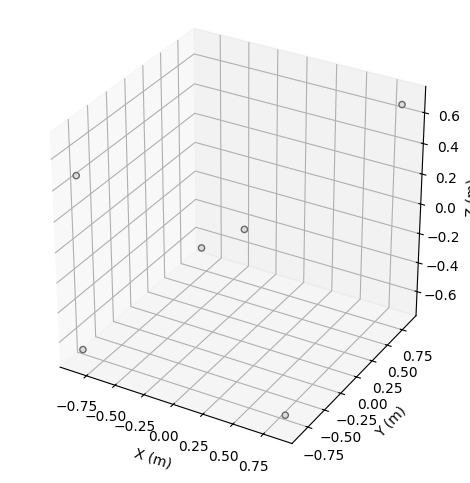

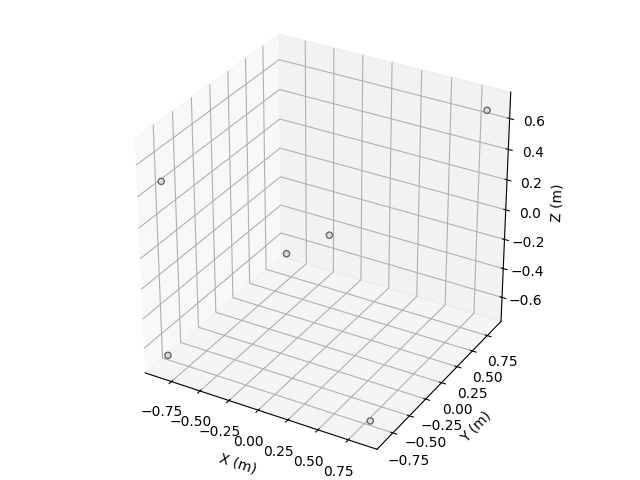

In [5]:
fig, ax = localization.plot_localizations3D(hydrophones=hydrophones_config)
fig

### Detection parameters
The third configuration file to define is the detection file. It is a .yaml files defining the different parameters used during the detection process. It includes the spectrogram, denoising and detections parameters. A description of each parameter can be found in the paper. An example of detection config file can be found [here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/detection_config_large_array.yaml).

Let's define and load the detection config file:

In [6]:
# Define config files
detection_config_file = r'large-array/detection_config_large_array.yaml'

# load configuration parameters
detection_config = ecosound.core.tools.read_yaml(detection_config_file)
detection_config

{'AUDIO': {'channel': 3},
 'SPECTROGRAM': {'frame_sec': 0.0625,
  'nfft_sec': 0.0853,
  'step_sec': 0.01,
  'fmin_hz': 0,
  'fmax_hz': 1000,
  'window_type': 'hann',
  'dB': True,
  'use_dask': True,
  'dask_chunks': 40},
 'DENOISER': {'denoiser_name': 'median_equalizer',
  'window_duration_sec': 3,
  'use_dask': True,
  'dask_chunks': [2048, 2000]},
 'DETECTOR': {'detector_name': 'BlobDetector',
  'kernel_duration_sec': 0.05,
  'kernel_bandwidth_hz': 300,
  'threshold': 20,
  'duration_min_sec': 0.05,
  'bandwidth_min_hz': 40,
  'use_dask': True,
  'dask_chunks': [2048, 2000]}}

### Localization parameters

The last configuration file is the localization file (.yaml) that defines the different parameters for the linearized inversion. An example of localization config file can be found [here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/localization_config_large_array.yaml).

Let's define and load the localization config file:

In [7]:
localization_config_file = r'large-array/localization_config_large_array.yaml'
localization_config = ecosound.core.tools.read_yaml(localization_config_file)
localization_config

{'ENVIRONMENT': {'sound_speed_mps': 1484},
 'TDOA': {'ref_channel': 3,
  'upsample_res_sec': 1e-07,
  'normalize': False,
  'min_corr_val': 0.8},
 'GRIDSEARCH': {'x_limits_m': [-1.5, 1.5],
  'y_limits_m': [-1.5, 1.5],
  'z_limits_m': [-1.0, 1.5],
  'spacing_m': 0.02},
 'INVERSION': {'start_model': [0, 0, 0],
  'start_model_repeats': 5,
  'damping_factor': 0.1,
  'stop_delta_m': 0.01,
  'stop_max_iteration': 100}}

Each parameter is explained below:
* **sound_speed_mps:** sound speed in the water, in meters per second
* **ref_channel:** reference channel for the TDOA measurements
* **upsample_res_sec:** time resolution desired for the cross correlation (in seconds)
* **min_corr_val:**  minimum correlation values accepted for considering a TDOA measurement valid
* **start_model:** coordinates of the first starting model to use in the linearized inversion (typically at teh center of the array, i.e. [0,0,0]).
* **start_model_repeats:** number of times the linearized inversion is repeated using different starting models.
* **damping_factor:** damping factor to use between iterations of the linearized inversion.
* **stop_delta_m:** stoping criteria. Stops when the difference of model norms between two consecutive iterations is less than stop_delta_m.
* **stop_max_iteration:** stoping criteria. Maximum number of iterations allowed.

## Step 3: Finding data from all hydrophones

We can now define the audio file we want to process. We can specify the name of a file from one hydrophone, and the code below will find out the corresponding files from the other hydrophones.

In [17]:
# Define file  to process
infile = r'synced_pairs/535_FishCam02_20190917T000426.219301Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0/AMAR173.1.20190917T000426Z_chunk000.wav'

# Look up data files for all channels
audio_files = tools.find_audio_files(infile, hydrophones_config)

The variable **audio_files** now lists the path and name of the audio files from each hydrophone.

In [18]:
audio_files

{'path': ['.\\large-array\\data/AMAR173.1.20190917T000426Z_chunk000.wav',
  '.\\large-array\\data/AMAR173.2.20190917T000426Z_chunk000.wav',
  '.\\large-array\\data/AMAR173.3.20190917T000426Z_chunk000.wav',
  '.\\large-array\\data/AMAR173.4.20190917T000426Z_chunk000.wav',
  '.\\large-array\\data/AMAR173.5.20190917T000426Z_chunk000.wav',
  '.\\large-array\\data/AMAR173.6.20190917T000426Z_chunk000.wav'],
 'channel': [0, 0, 0, 0, 0, 0]}

In [19]:
#modified for mac file paths
audio_files['path'] = [
    p.replace('\\', '/') for p in audio_files['path']
]

for p in audio_files['path']:
    print(p)


./large-array/data/AMAR173.1.20190917T000426Z_chunk000.wav
./large-array/data/AMAR173.2.20190917T000426Z_chunk000.wav
./large-array/data/AMAR173.3.20190917T000426Z_chunk000.wav
./large-array/data/AMAR173.4.20190917T000426Z_chunk000.wav
./large-array/data/AMAR173.5.20190917T000426Z_chunk000.wav
./large-array/data/AMAR173.6.20190917T000426Z_chunk000.wav


We can then inspect the data from all channels by displaying the spectrograms and waveforms. The spectrogram parameters used for the spectrograms are the ones defined in the detection_config file defined earlier.

In [20]:
# plot all data 
graph_spectros, graph_waveforms = tools.plot_all_channels(audio_files,
                                                          detection_config['SPECTROGRAM']['frame_sec'],
                                                          detection_config['SPECTROGRAM']['window_type'],
                                                          detection_config['SPECTROGRAM']['nfft_sec'],
                                                          detection_config['SPECTROGRAM']['step_sec'],
                                                          detection_config['SPECTROGRAM']['fmin_hz'],
                                                          detection_config['SPECTROGRAM']['fmax_hz'],
                                                          detections_channel=detection_config['AUDIO']['channel'],
                                                          verbose=False)

#graph_spectros.show(display=False)
fig_graph_waveforms, ax_graph_waveforms = graph_waveforms.show(display=False)
fig_graph_spectros, ax_graph_spectros = graph_spectros.show(display=False)

Stacked spectrograms for all hydrophones:

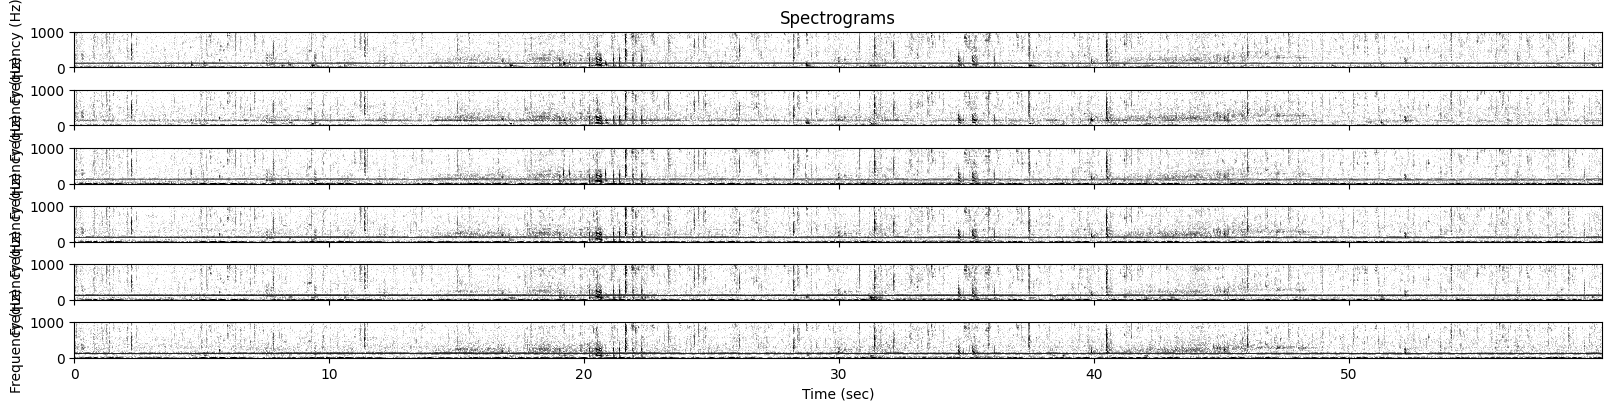

In [21]:
fig_graph_spectros

Stacked waveforms for all hydrophones:

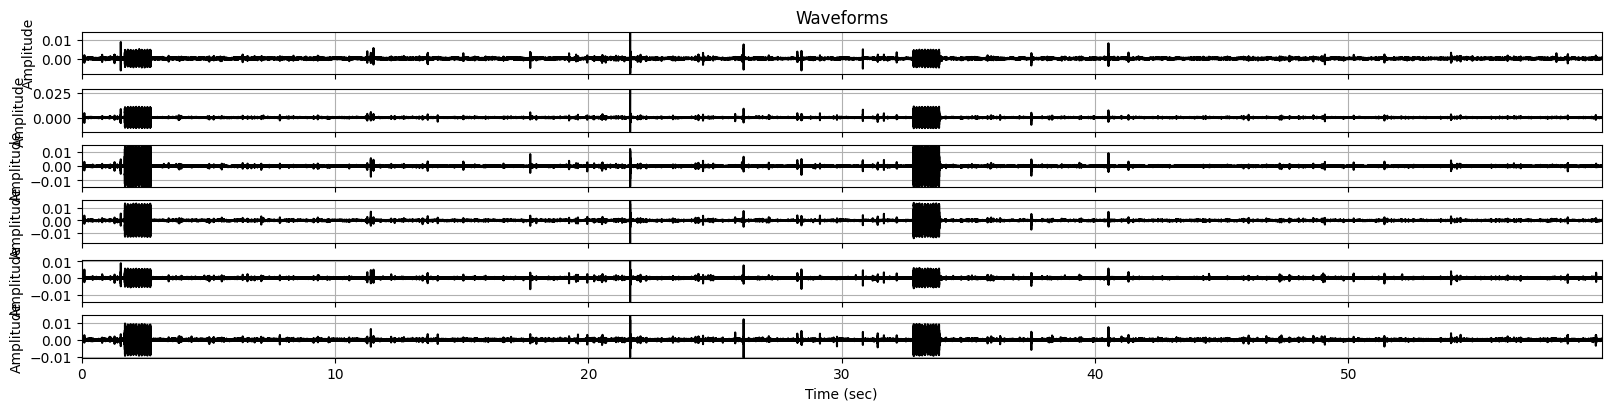

In [22]:
fig_graph_waveforms

## Step 4: Running the automatic detector

The detector can now be run on one of the hydrophones using the function **detection.run_detector**. The input arguments for that function are (in this order):
1. The path of the file to process, 
2. The channel to use,
3. the detection_config parameters (see step 2),
4. the path of the deployment_info file (see step 2). 

In [23]:
# run detector on selected channel
detections = detection.run_detector(audio_files['path'][detection_config['AUDIO']['channel']],
                                    audio_files['channel'][detection_config['AUDIO']['channel']],
                                    detection_config,
                                    deployment_file=deployment_info_file)

The detector returns the variable **detections**, which is an ecosound annotation object. All detections can be found in **detections.data**. The start and stop times of each detection are defined by the fields **time_min_offset** and **time_max_offset**, respectively. The minimum and maximum frequency of the detection boxes are defined by the fields **frequency_min** and **frequency_min**, respectively.

Here, we see that the algorithm found 34 detections:

In [24]:
# Look at detection table
detections.data

,uuid,from_detector,software_name,software_version,operator_name,UTC_offset,entry_date,audio_channel,audio_file_name,audio_file_dir,...,frequency_min,frequency_max,time_min_offset,time_max_offset,time_min_date,time_max_date,duration,label_class,label_subclass,confidence
0,4ebab62d-7500-4eb1-bb41-440fce4c854f,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,656.2500,1007.8125,0.05,0.11,2019-09-17 00:04:26.050,2019-09-17 00:04:26.110,0.06,NaN,NaN,NaN
1,5007b04a-0860-4c7e-9637-fb5f1704ce68,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,109.3750,500.0000,0.28,0.36,2019-09-17 00:04:26.280,2019-09-17 00:04:26.360,0.08,NaN,NaN,NaN
2,79731640-7ff4-4225-a03a-1d5426baa64f,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,757.8125,1007.8125,0.76,0.81,2019-09-17 00:04:26.760,2019-09-17 00:04:26.810,0.05,NaN,NaN,NaN
3,54d07a6d-ecaf-4872-967f-4253e1b2a93a,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,578.1250,1007.8125,1.24,1.30,2019-09-17 00:04:27.240,2019-09-17 00:04:27.300,0.06,NaN,NaN,NaN
4,23775e0e-fadd-453f-ab32-45a3169d3463,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,789.0625,1007.8125,1.35,1.41,2019-09-17 00:04:27.350,2019-09-17 00:04:27.410,0.06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,bfc2a2ef-987e-44ed-8ef9-77f77248d090,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,101.5625,468.7500,56.60,56.65,2019-09-17 00:05:22.600,2019-09-17 00:05:22.650,0.05,NaN,NaN,NaN
117,c858dfe5-3e5f-4a02-80fe-cdd2a3a22c2c,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,640.6250,1007.8125,57.81,57.85,2019-09-17 00:05:23.810,2019-09-17 00:05:23.850,0.04,NaN,NaN,NaN
118,b4110a1f-883b-47fb-9dcd-21ddb78f59ff,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,406.2500,992.1875,58.60,58.67,2019-09-17 00:05:24.600,2019-09-17 00:05:24.670,0.07,NaN,NaN,NaN
119,9d52a439-38cd-45d4-b092-fb4773dbddcb,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,0.0000,507.8125,59.22,59.27,2019-09-17 00:05:25.220,2019-09-17 00:05:25.270,0.05,NaN,NaN,NaN


We can inspect the detections by ploting their time and frequency boxes on top of the spectrogram and waveform:

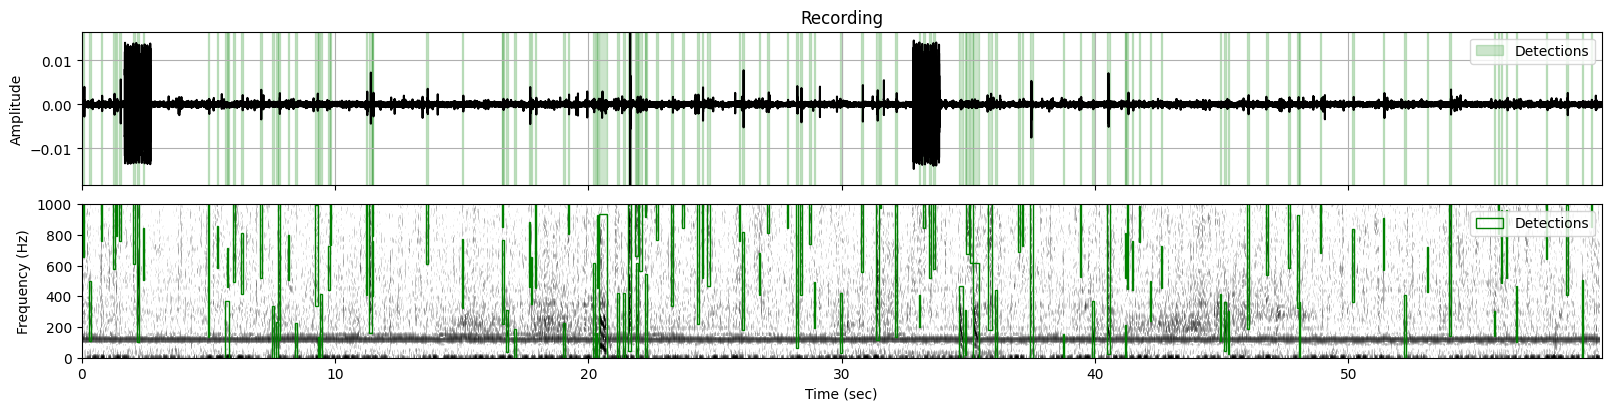

In [25]:
# plot detections
graph_detec = tools.plot_single_channel(audio_files['path'][detection_config['AUDIO']['channel']],
                                  detection_config['SPECTROGRAM']['frame_sec'],
                                  detection_config['SPECTROGRAM']['window_type'],
                                  detection_config['SPECTROGRAM']['nfft_sec'],
                                  detection_config['SPECTROGRAM']['step_sec'],
                                  detection_config['SPECTROGRAM']['fmin_hz'],
                                  detection_config['SPECTROGRAM']['fmax_hz'],
                                  detections=detections,
                                  verbose=False)
fig_graph_detec, ax_graph_detec = graph_detec.show(display=False)
fig_graph_detec

## Step 5: Localizing the detected signals

Now we can localize the detected signals using linearized inversion with data from all hydrophones. The code below may take several seconds.

In [26]:
# Perform localization using linearized invertion
localizations = localization.LinearizedInversion.run_localization(audio_files, detections, deployment_info_file, detection_config, hydrophones_config, localization_config, verbose=False)

...done


The localization results are in the **localizations** variable. It contains the same number of rows as the variable **detections**. Localization details can be found in **localizations.data**, and the localization fileds are as follows:
* **x**, **y**, and **z** define the coordinates of the localizations
* **x_err_low** and **x_err_high**, **y_err_low** and **y_err_high**,and **z_err_low** and **z_err_high** are the low and high localization uncertainties for each dimension.
* **x_err_span**, **y_err_span**, and **z_err_span** define the span of the uncertainties in each dimension (i.e., x_err_span = x_err_high - x_err_low).

In [27]:
localizations.data

,uuid,from_detector,software_name,software_version,operator_name,UTC_offset,entry_date,audio_channel,audio_file_name,audio_file_dir,...,x_err_high,x_err_span,y_err_low,y_err_high,y_err_span,z_err_low,z_err_high,z_err_span,tdoa_errors_std,iterations_logs
0,4ebab62d-7500-4eb1-bb41-440fce4c854f,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5007b04a-0860-4c7e-9637-fb5f1704ce68,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79731640-7ff4-4225-a03a-1d5426baa64f,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54d07a6d-ecaf-4872-967f-4253e1b2a93a,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23775e0e-fadd-453f-ab32-45a3169d3463,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,bfc2a2ef-987e-44ed-8ef9-77f77248d090,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,c858dfe5-3e5f-4a02-80fe-cdd2a3a22c2c,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,b4110a1f-883b-47fb-9dcd-21ddb78f59ff,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x y z ...
119,9d52a439-38cd-45d4-b092-fb4773dbddcb,True,BlobDetector,0.1,dhcp-10-29-204-136.dyn.mit.edu,-7.0,2026-02-16 16:22:12.497054,0.0,AMAR173.4.20190917T000426Z_chunk000,./large-array/data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that some rows (i.e., detections) could not be localized (i.e., localization fields = NaNs) because the correlation value during the TDOA measurement process was too low, or because the linearized inversion process did not converge. There are also localizations that have large uncertainties that would not be very useful for matching with the video data.

So, we can filter the localizations so we only keep the ones with an uncertainty span less than 1 m:

In [28]:
# Show that some detections with no localizations (nan) -> did not converge

# Filter localization results to only keep results with low uncertainty
localizations.filter("x_err_span < 1 & y_err_span < 1 & z_err_span < 1.5", inplace=True)



When we plot the signals that are remaining (after filtering the localizations with large uncertainties), we see that it kept all the fish sounds:

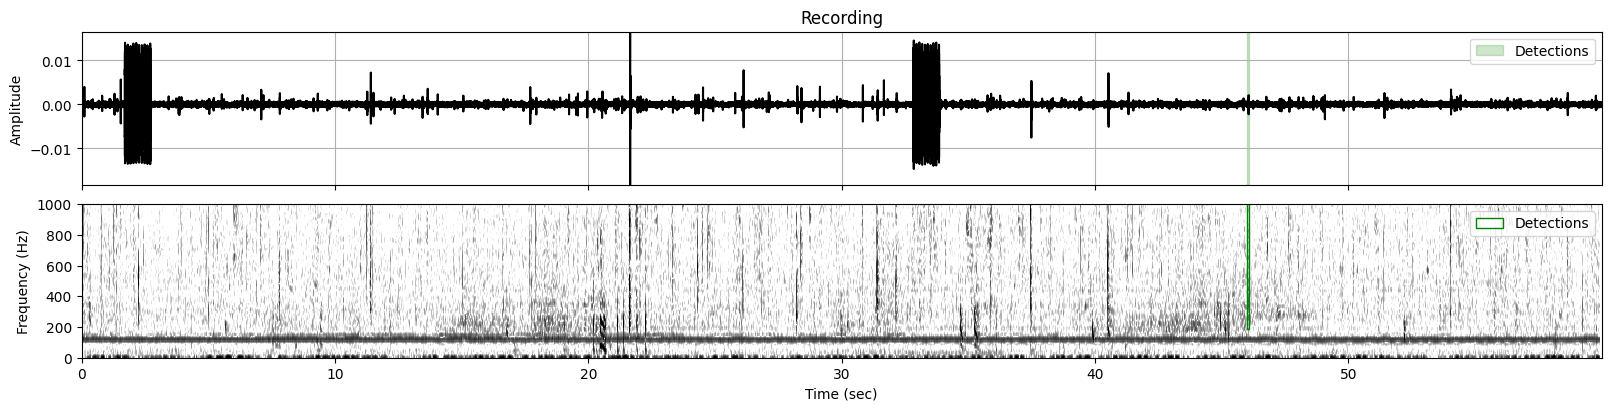

In [29]:
# plot spectrogram with measurements filtered
graph_loc = tools.plot_single_channel(audio_files['path'][detection_config['AUDIO']['channel']],
                                      detection_config['SPECTROGRAM']['frame_sec'],
                                      detection_config['SPECTROGRAM']['window_type'],
                                      detection_config['SPECTROGRAM']['nfft_sec'],
                                      detection_config['SPECTROGRAM']['step_sec'],
                                      detection_config['SPECTROGRAM']['fmin_hz'],
                                      detection_config['SPECTROGRAM']['fmax_hz'],
                                      detections=localizations,
                                      verbose=False)
fig_graph_loc, ax_graph_loc = graph_loc.show(display=False)
fig_graph_loc

Finally, we can visualize the localizations (blue dots) with their unceratinties (red bars) in a 3D scatter plot:

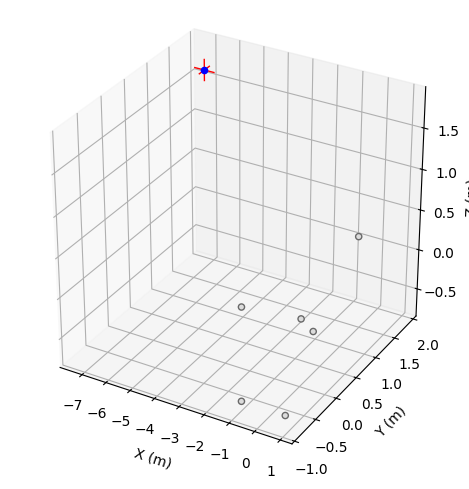

In [30]:
# Plot localizations
fig_loc, fig_ax = localization.plot_localizations3D(localizations=localizations, hydrophones=hydrophones_config)
fig_loc

## Step 6: Saving the localization results
The loclaization results can be saved to a csv file and/or a netcdf file that can be used later on by ecosound:

In [5]:
# save as csv:
localizations.to_csv('localization_results.csv')

# save as netcdf
localizations.data.drop(columns=['iterations_logs'],inplace=True)
localizations.to_netcdf('localization_results.nc')

NameError: name 'localizations' is not defined

## Step 7: Heatmap

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

# Clicked pixel locations of the 4 FRAME corners (not hydrophones!)
corner_pixels = {
    "BL": (445, 840),   # bottom-left frame corner
    "BR": (1174, 867),  # bottom-right frame corner
    "TL": (456, 120),   # top-left frame corner
    "TR": (1188, 145),   
}

# World coordinates of those same corners in the top-down plane (x, y)
corner_world_xy = {
    "BL": (-0.858, -0.86),
    "BR": ( 0.858, -0.86),
    "TL": (-0.858,  0.86),
    "TR": ( 0.858,  0.86),
}

In [35]:
order = ["BL", "BR", "TL", "TR"]
W = np.array([corner_world_xy[k] for k in order], dtype=np.float32)
U = np.array([corner_pixels[k]   for k in order], dtype=np.float32)

H, _ = cv2.findHomography(W, U, method=0)

def project_xy(xy_list, H):
    pts = np.asarray(xy_list, dtype=np.float32).reshape(1, -1, 2)
    return cv2.perspectiveTransform(pts, H)[0]

In [36]:
REFERENCE_IMAGE_PATH = "/Users/wendycao/fish/reference_frame.png"  # change this

img_bgr = cv2.imread(REFERENCE_IMAGE_PATH)
if img_bgr is None:
    raise FileNotFoundError(REFERENCE_IMAGE_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Project the corners back (should land exactly on clicks)
U_hat = project_xy(W, H)

plt.figure(figsize=(10,7))
plt.imshow(img_rgb)
plt.title("Frame-corner homography check (circles=projected, x=clicked)")

# projected corners
for k, (u,v) in zip(order, U_hat):
    plt.scatter([u], [v], s=120)
    plt.text(u+8, v-8, k, fontsize=11, weight="bold")

# clicked corners
for k, (u,v) in corner_pixels.items():
    plt.scatter([u], [v], marker="x", s=160)
    plt.text(u+8, v+18, f"click {k}", fontsize=9)

plt.axis("off")
plt.savefig("frame_corner_homography_check.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: frame_corner_homography_check.png")


Saved: frame_corner_homography_check.png


In [37]:
hydrophone_world_xy = {
    int(row.array_channel): (float(row.x), float(row.y))
    for _, row in hydrophones_config.iterrows()
}

In [38]:
def project_xy(xy_list, H):
    pts = np.asarray(xy_list, dtype=np.float32).reshape(1, -1, 2)  # (1,N,2)
    return cv2.perspectiveTransform(pts, H)[0]  # (N,2)

all_ids = sorted(hydrophone_world_xy.keys())
W = np.array([hydrophone_world_xy[i] for i in all_ids], dtype=np.float32)
U = project_xy(W, H)   # pixel coords

for i, (u,v) in zip(all_ids, U):
    print(f"cfg{i} -> pixel ({u:.1f}, {v:.1f})")

cfg0 -> pixel (445.0, 840.0)
cfg1 -> pixel (445.0, 840.0)
cfg2 -> pixel (1174.0, 867.0)
cfg3 -> pixel (827.1, 494.1)
cfg4 -> pixel (456.0, 120.0)
cfg5 -> pixel (1188.0, 145.0)


In [39]:


plt.figure(figsize=(10,7))
plt.imshow(img_rgb)
plt.title("Projected hydrophone positions from frame-corner homography")

# circles = projected hydrophones
for i, (u, v) in zip(all_ids, U):
    plt.scatter([u], [v], s=120)
    plt.text(u+8, v-8, f"cfg{i}", fontsize=11, weight="bold")

plt.axis("off")
plt.savefig("projected_hydrophones.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: projected_hydrophones.png")


Saved: projected_hydrophones.png


## projecting localized coordinates

In [43]:
def world_to_pixel(x, y, H):
    pt = np.array([[[x, y]]], dtype=np.float32)
    uv = cv2.perspectiveTransform(pt, H)[0, 0]
    return int(round(uv[0])), int(round(uv[1]))


In [45]:
def make_gaussian_heatmap(height, width, u, v, sigma=35):
    """
    Returns heatmap in [0,1], brightest at (u,v).
    u,v are pixel coordinates (int or float).
    """
    xs = np.arange(width, dtype=np.float32)
    ys = np.arange(height, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys)
    heat = np.exp(-((X - u)**2 + (Y - v)**2) / (2 * sigma**2))
    heat /= (heat.max() + 1e-8)
    return heat

def overlay_heatmap_on_frame(frame_bgr, heat, alpha=0.45, colormap=cv2.COLORMAP_JET):
    """
    heat: [0,1] float array (H,W)
    returns: BGR image with heatmap overlay
    """
    heat8 = (255 * np.clip(heat, 0, 1)).astype(np.uint8)
    heat_color = cv2.applyColorMap(heat8, colormap)   # BGR output
    out = cv2.addWeighted(heat_color, alpha, frame_bgr, 1 - alpha, 0)
    return out

def save_detection_frames_from_csv(
    video_path,
    csv_path,
    H,
    out_dir="detection_frames",
    radius_px=10,
    coord_cols=("x", "y"),
    heat_sigma_px=35,          # <-- NEW: spread of heatmap
    heat_alpha=0.45,           # <-- NEW: overlay strength
    save_raw_heatmap=False     # <-- NEW: optionally save heat .npy
):
    os.makedirs(out_dir, exist_ok=True)

    df = pd.read_csv(csv_path)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video FPS: {fps:.2f}")

    for _, row in df.iterrows():
        t = float(row["time_min_offset"])
        frame_idx = int(round(t * fps))

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        if not ok:
            print(f"Could not read frame {frame_idx}, skipping")
            continue

        # --- project localization ---
        x_name, y_name = coord_cols
        x, y = float(row[x_name]), float(row[y_name])
        u, v = world_to_pixel(x, y, H)
        u_i, v_i = int(round(u)), int(round(v))

        if 0 <= u_i < width and 0 <= v_i < height:
            conf = float(row.get("confidence", 1.0))
            conf = max(0.0, min(1.0, conf))

            # --- NEW: heatmap overlay ---
            heat = make_gaussian_heatmap(height, width, u, v, sigma=heat_sigma_px)

            # scale heat by confidence (optional but usually matches what you want)
            heat *= conf

            frame = overlay_heatmap_on_frame(frame, heat, alpha=heat_alpha)

            # keep your point marker on top (optional)
            color = (0, int(255 * conf), int(255 * (1 - conf)))
            cv2.circle(frame, (u_i, v_i), radius_px, (255, 255, 255), -1)

            cv2.putText(
                frame,
                f"{x_name}={x:.2f}, {y_name}={y:.2f}, t={t:.2f}s, conf={conf:.2f}",
                (max(u_i - 120, 5), max(v_i - 15, 15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2,
            )

        else:
            cv2.putText(
                frame,
                "Projected point out of frame",
                (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 255),
                2,
            )

        uuid = row["uuid"]
        out_path = os.path.join(out_dir, f"{uuid}_frame{frame_idx:06d}.png")
        cv2.imwrite(out_path, frame)
        print("Saved:", out_path)

        # optional: save the raw heatmap for later analysis
        if save_raw_heatmap and (0 <= u_i < width and 0 <= v_i < height):
            np.save(os.path.join(out_dir, f"{uuid}_frame{frame_idx:06d}_heat.npy"), heat)

    cap.release()

In [53]:
save_detection_frames_from_csv(
    video_path="/Users/wendycao/fish/3420_FishCam01_20190920T163858Z_aligned_17s.mp4",
    csv_path="/Users/wendycao/fish/XAV-arrays/localization/localization_results.csv",
    H=H,   # your frame-corner homography
    out_dir="debug_detection_frames",
    radius_px=12
)


Video FPS: 10.00
Saved: debug_detection_frames/5076edef-4d83-4175-bd63-cf47d9c931a9_frame000013.png
Saved: debug_detection_frames/901223e7-dec0-46a5-a718-62a2717611be_frame000017.png
Saved: debug_detection_frames/925ba256-3393-4ba7-9b61-b77800ebce15_frame000023.png
Saved: debug_detection_frames/a5cb395b-dae9-4922-af25-d0f5552f194c_frame000099.png
Saved: debug_detection_frames/16596455-606d-437a-9f7c-0675cfaa1db4_frame000114.png
Saved: debug_detection_frames/9373e0c2-0b6e-47a0-b947-247dcb019de5_frame000116.png
Saved: debug_detection_frames/6a42de1b-78f3-4090-9fd6-b01424dda855_frame000118.png
Saved: debug_detection_frames/ff25cc39-6394-4e3b-b180-52a865718f56_frame000128.png
Saved: debug_detection_frames/64a2677f-d42a-485e-9438-59123a4295b2_frame000129.png
Saved: debug_detection_frames/6bdf2f80-65db-4d88-bda7-c0dd8dca1c7e_frame000130.png
Saved: debug_detection_frames/e6423370-225b-45a8-932d-9ca2f2601f69_frame000134.png
Saved: debug_detection_frames/143ba019-8b37-4a80-94e5-aacdb94c387a_fra

# Generate Heatmap

In [47]:
import os
import numpy as np
import pandas as pd
import cv2
import soundfile as sf

In [48]:
def project_xy(x, y, H):
    pt = np.array([[[float(x), float(y)]]], dtype=np.float32)
    uv = cv2.perspectiveTransform(pt, H.astype(np.float32))[0, 0]
    return int(round(float(uv[0]))), int(round(float(uv[1])))

def gaussian_smooth(heat, sigma_px):
    return cv2.GaussianBlur(heat, ksize=(0, 0), sigmaX=sigma_px, sigmaY=sigma_px)

def heat_to_colormap(heat):
    h = heat.astype(np.float32)
    h = h / (h.max() + 1e-8)
    heat_u8 = np.clip(255 * h, 0, 255).astype(np.uint8)
    return cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)  # BGR

def overlay_heat(frame_bgr, heat_smooth, alpha=0.45):
    heat_color = heat_to_colormap(heat_smooth)
    if heat_color.shape[:2] != frame_bgr.shape[:2]:
        heat_color = cv2.resize(heat_color, (frame_bgr.shape[1], frame_bgr.shape[0]))
    return cv2.addWeighted(frame_bgr, 1 - alpha, heat_color, alpha, 0)

def compute_window_energy(audio_mn, sr, t0, t1):
    """
    audio_mn: (M,N) float32
    t0,t1 in seconds (offsets into file)
    returns sum_m sum_n s_m[n]^2 over the window
    """
    i0 = max(0, int(np.floor(t0 * sr)))
    i1 = min(audio_mn.shape[1], int(np.ceil(t1 * sr)))
    if i1 <= i0:
        return 0.0
    seg = audio_mn[:, i0:i1]
    return float(np.sum(seg * seg))

In [49]:
def heatmap_from_localizations_csv(
    video_path,
    csv_path,
    out_dir="out_heat_csv",
    audio_path=None,                 # if provided, compute energy from audio windows
    sigma_px=25.0,
    overlay_alpha=0.45,
    weight_mode="energy",            # "energy", "confidence", "uniform"
    coord_cols=("x", "y"),
):
    os.makedirs(out_dir, exist_ok=True)

    # Read one frame for dimensions + overlay base
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    Himg = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    ok, frame0 = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError("Could not read first frame")

    heat = np.zeros((Himg, W), dtype=np.float32)

    # Load detections/localizations
    df = pd.read_csv(csv_path)

    # If computing energy from audio, load it once
    audio_mn = None
    sr = None
    if audio_path is not None:
        audio, sr = sf.read(audio_path, always_2d=True)  # (N,M)
        audio = audio.astype(np.float32)
        audio_mn = audio.T  # (M,N)
        sr = int(sr)
        print(f"[audio] loaded {audio_path}, sr={sr}, shape={audio_mn.shape}")

    # Accumulate
    kept = 0
    for _, row in df.iterrows():
        x_name, y_name = coord_cols
        x, y = float(row[x_name]), float(row[y_name])
        u, v = project_xy(x, y, H)

        if not (0 <= u < W and 0 <= v < Himg):
            continue

        # Weight
        if weight_mode == "uniform":
            w = 1.0

        elif weight_mode == "confidence":
            w = float(row.get("confidence", 1.0))

        elif weight_mode == "energy":
            if audio_mn is None:
                # fallback if no audio available: duration-weighted confidence
                dur = float(row.get("duration", 1.0))
                conf = float(row.get("confidence", 1.0))
                w = dur * conf
            else:
                t0 = float(row["time_min_offset"])
                t1 = float(row["time_max_offset"])
                w = compute_window_energy(audio_mn, sr, t0, t1)

        else:
            raise ValueError(f"Unknown weight_mode: {weight_mode}")

        heat[v, u] += float(w)
        kept += 1

    print(f"[heat] accumulated {kept}/{len(df)} rows into heatmap")

    # Smooth (your requested line)
    heat_smooth = gaussian_smooth(heat, sigma_px=sigma_px)

    # Save arrays
    np.save(os.path.join(out_dir, "heat_raw.npy"), heat)
    np.save(os.path.join(out_dir, "heat_smooth.npy"), heat_smooth)

    # Overlay image (first frame)
    overlay_img = overlay_heat(frame0, heat_smooth, alpha=overlay_alpha)
    out_png = os.path.join(out_dir, "heat_overlay_first_frame.png")
    cv2.imwrite(out_png, overlay_img)

    print("[out] saved:")
    print(" ", out_png)
    print(" ", os.path.join(out_dir, "heat_raw.npy"))
    print(" ", os.path.join(out_dir, "heat_smooth.npy"))

    return heat, heat_smooth

In [54]:
if __name__ == "__main__":
    heatmap_from_localizations_csv(
        video_path="/Users/wendycao/fish/3420_FishCam01_20190920T163858Z_aligned_17s.mp4",
        csv_path="/Users/wendycao/fish/XAV-arrays/localization/localization_results.csv",
        out_dir="out_heat_csv",
        audio_path=None,
        sigma_px=25.0,
        overlay_alpha=0.45,
        weight_mode="energy",  # or "confidence" / "uniform"
    )

[heat] accumulated 12/12 rows into heatmap
[out] saved:
  out_heat_csv/heat_overlay_first_frame.png
  out_heat_csv/heat_raw.npy
  out_heat_csv/heat_smooth.npy


/var/folders/xs/2mdlsqc56b76kyrbbjkjvyvr0000gn/T/ipykernel_2187/2852142503.py:12: RuntimeWarning: invalid value encountered in cast
  heat_u8 = np.clip(255 * h, 0, 255).astype(np.uint8)


In [42]:
import numpy as np
np.save("/Users/wendycao/fish/XAV-arrays/localization/frame_corner_H.npy", H)


# Overlaying Video

In [55]:
import os
import numpy as np
import pandas as pd
import cv2
import soundfile as sf

# ============================================================
# 1) Helpers
# ============================================================
def project_xy(x, y, H):
    pt = np.array([[[float(x), float(y)]]], dtype=np.float32)
    uv = cv2.perspectiveTransform(pt, H.astype(np.float32))[0, 0]
    return int(round(float(uv[0]))), int(round(float(uv[1])))

def compute_window_energy(audio_mn, sr, t0, t1):
    """Energy across all channels over [t0,t1] seconds."""
    i0 = max(0, int(np.floor(t0 * sr)))
    i1 = min(audio_mn.shape[1], int(np.ceil(t1 * sr)))
    if i1 <= i0:
        return 0.0
    seg = audio_mn[:, i0:i1]
    return float(np.sum(seg * seg))

def heat_to_colormap(heat):
    h = heat.astype(np.float32)
    h = h / (h.max() + 1e-8)
    heat_u8 = np.clip(255 * h, 0, 255).astype(np.uint8)
    return cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)  # BGR

def overlay_heat(frame_bgr, heat_smooth, alpha=0.45):
    heat_color = heat_to_colormap(heat_smooth)
    if heat_color.shape[:2] != frame_bgr.shape[:2]:
        heat_color = cv2.resize(heat_color, (frame_bgr.shape[1], frame_bgr.shape[0]))
    return cv2.addWeighted(frame_bgr, 1 - alpha, heat_color, alpha, 0)


# ============================================================
# 2) Build per-event table: time -> frame, plane coords -> (u,v), weight w
# ============================================================
def build_event_table(
    df,
    video_w,
    video_h,
    fps,
    H,
    weight_mode="confidence",   # "confidence" | "energy" | "uniform"
    audio_path=None,            # required if weight_mode="energy" and you want true energy
    time_offset_sec=0.0,        # IMPORTANT: add if video is not aligned to audio start
    coord_cols=("x", "y")
):
    """
    Returns DataFrame with columns: frame_idx, u, v, w
    Uses CSV columns:
      time_min_offset, time_max_offset, x, y, confidence, duration
    """
    audio_mn, sr = None, None
    if weight_mode == "energy" and audio_path is not None:
        audio, sr = sf.read(audio_path, always_2d=True)  # (N,M)
        audio_mn = audio.astype(np.float32).T            # (M,N)
        sr = int(sr)
        print(f"[audio] loaded for energy weights: sr={sr}, shape={audio_mn.shape}")

    rows = []
    for _, r in df.iterrows():
        t0 = float(r["time_min_offset"])
        t1 = float(r["time_max_offset"]) if "time_max_offset" in df.columns else t0

        # map event time -> video frame
        frame_idx = int(round((t0 + float(time_offset_sec)) * fps))

        # project localization -> pixel
        x_name, y_name = coord_cols
        x_val = r[x_name]
        y_val = r[y_name]
        u, v = project_xy(x_val, y_val, H)
        if not (0 <= u < video_w and 0 <= v < video_h):
            continue

        # weight
        if weight_mode == "uniform":
            w = 1.0
        elif weight_mode == "confidence":
            conf = r.get("confidence", np.nan)
            w = 1.0 if pd.isna(conf) else float(conf)
        elif weight_mode == "energy":
            if audio_mn is None:
                # fallback if no audio provided
                conf = float(r.get("confidence", 1.0))
                dur  = float(r.get("duration", 1.0))
                w = conf * dur
            else:
                w = compute_window_energy(audio_mn, sr, t0, t1)
        else:
            raise ValueError("weight_mode must be one of: uniform, confidence, energy")

        rows.append((frame_idx, u, v, float(w)))

    return pd.DataFrame(rows, columns=["frame_idx", "u", "v", "w"])

# ============================================================
# 3) Debug helper: save one frame with projected dots
# ============================================================
def save_debug_projection_frame(video_path, events, out_png="debug_projection.png", target_frame=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = float(cap.get(cv2.CAP_PROP_FPS))

    if target_frame is None:
        if len(events) > 0:
            # pick a frame that actually has events, if possible
            counts = events["frame_idx"].value_counts()
            target_frame = int(counts.index[0])
        else:
            target_frame = n_frames // 2

    cap.set(cv2.CAP_PROP_POS_FRAMES, int(target_frame))
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read frame {target_frame}")

    subset = events[events["frame_idx"] == int(target_frame)]
    print(f"[debug] frame={target_frame} has {len(subset)} events (t={target_frame/fps:.2f}s)")

    for _, r in subset.iterrows():
        u, v = int(r["u"]), int(r["v"])
        cv2.circle(frame, (u, v), 10, (0, 255, 0), -1)

    cv2.putText(frame, f"frame={target_frame} events={len(subset)}",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    cv2.imwrite(out_png, frame)
    print("Saved:", out_png)

# ============================================================
# 4) Render time-varying heat overlay video
# ============================================================
def make_time_varying_heat_overlay_video(
    video_path,
    localizations_csv,
    out_video_path="heat_trail_overlay.mp4",
    audio_path=None,
    weight_mode="confidence",   # "confidence" | "energy" | "uniform"
    mode="trail",              # "trail" | "cumulative"
    window_sec=1.5,            # only for trail mode
    sigma_px=25.0,
    alpha=0.45,
    time_offset_sec=0.0,       # IMPORTANT if video not aligned to audio
    max_frames=None,
    coord_cols=("x", "y"),
    debug=True
):
    df = pd.read_csv(localizations_csv)

    c1_name, c2_name = coord_cols
    if c1_name not in df.columns or c2_name not in df.columns:
        raise KeyError(f"Could not find columns {coord_cols} in CSV. Columns: {list(df.columns)}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    fps = float(cap.get(cv2.CAP_PROP_FPS))
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    Hh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    n_frames = n_frames_total if max_frames is None else min(n_frames_total, int(max_frames))
    print(f"[video] fps={fps:.2f}, size={W}x{Hh}, frames={n_frames} (total={n_frames_total})")

    # Build event table
    events = build_event_table(
        df, video_w=W, video_h=Hh, fps=fps, H=H,
        weight_mode=weight_mode, audio_path=audio_path,
        time_offset_sec=time_offset_sec, coord_cols=coord_cols
    )

    print("[events] usable events:", len(events))
    if len(events) > 0:
        print("[events] frame_idx min/max:", int(events["frame_idx"].min()), int(events["frame_idx"].max()))
        print("[events] u min/max:", int(events["u"].min()), int(events["u"].max()))
        print("[events] v min/max:", int(events["v"].min()), int(events["v"].max()))
        print("[events] w min/max:", float(events["w"].min()), float(events["w"].max()))
    else:
        print("No events survived filtering. Likely time_offset_sec or projection mismatch.")

    # Optional: save a debug frame with projected dots
    if debug:
        save_debug_projection_frame(video_path, events, out_png="debug_projection.png")

    # Group events by frame
    # Pre-group events by frame using plain ints to avoid dtype mismatches.
    events_by_frame = (
        {int(k): g for k, g in events.groupby("frame_idx")} if len(events) > 0 else {}
    )

    # Prepare writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_video_path, fourcc, fps, (W, Hh))

    # Heat buffer
    heat = np.zeros((Hh, W), dtype=np.float32)

    # Trail queue for subtracting old contributions
    window_frames = int(round(window_sec * fps))
    frame_adds = [None] * n_frames  # list of lists of (v,u,w) per frame

    frame_idx = 0
    while frame_idx < n_frames:
        ok, frame = cap.read()
        if not ok:
            break

        adds = []
        g = events_by_frame.get(int(frame_idx))
        if g is not None:
            for _, r in g.iterrows():
                u, v, w = int(r["u"]), int(r["v"]), float(r["w"])
                if not np.isfinite(w) or w <= 0:
                    continue
                heat[v, u] += w
                adds.append((v, u, w))
        frame_adds[frame_idx] = adds

        # Trail subtraction
        if mode == "trail" and frame_idx - window_frames >= 0:
            old = frame_adds[frame_idx - window_frames]
            if old:
                for v, u, w in old:
                    heat[v, u] -= w
                np.maximum(heat, 0, out=heat)

        # Debug: see if heat is nonzero
        if debug and frame_idx % 50 == 0:
            print(f"[render] frame {frame_idx}/{n_frames} | adds={len(adds)} | heat.max={float(heat.max()):.6g}")

        # Smooth (requested feature)
        heat_smooth = cv2.GaussianBlur(
            heat, ksize=(0, 0),
            sigmaX=float(sigma_px), sigmaY=float(sigma_px)
        )

        # Overlay
        out = overlay_heat(frame, heat_smooth, alpha=alpha)

        # Draw debug text
        cv2.putText(out, f"{mode}  t={frame_idx/fps:.2f}s  adds={len(adds)}",
                    (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

        writer.write(out)
        frame_idx += 1

    cap.release()
    writer.release()
    print("Wrote:", out_video_path)



In [56]:
make_time_varying_heat_overlay_video(
    
    video_path="/Users/wendycao/fish/3420_FishCam01_20190920T163858Z_aligned_17s.mp4",
    localizations_csv="/Users/wendycao/fish/XAV-arrays/localization/localization_results.csv",
    out_video_path="heat_trail_overlay_strong.mp4",
    weight_mode="confidence",
    mode="trail",
    window_sec=2.0,
    sigma_px=20.0,   # smaller = sharper
    alpha=0.5,       # stronger overlay
    debug=True,
)


[video] fps=10.00, size=1600x1200, frames=174 (total=174)
[events] usable events: 12
[events] frame_idx min/max: 13 137
[events] u min/max: 362 638
[events] v min/max: 421 605
[events] w min/max: 1.0 1.0
[debug] frame=13 has 1 events (t=1.30s)
Saved: debug_projection.png
[render] frame 0/174 | adds=0 | heat.max=0
[render] frame 50/174 | adds=0 | heat.max=0
[render] frame 100/174 | adds=0 | heat.max=1
[render] frame 150/174 | adds=0 | heat.max=1
Wrote: heat_trail_overlay_strong.mp4


In [45]:
import pandas as pd
df = pd.read_csv("/Users/wendycao/fish/XAV-arrays/localization/localization_results.csv")
df[["x_err_span","y_err_span","x_err_low","x_err_high","y_err_low","y_err_high"]].describe()


,x_err_span,y_err_span,x_err_low,x_err_high,y_err_low,y_err_high
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.358298,0.259645,-1.058070,-0.699772,-0.161748,0.097898
std,0.101702,0.054202,0.283835,0.207101,0.140701,0.178051
min,0.211829,0.203015,-1.255059,-0.910858,-0.394963,-0.179421
25%,0.290793,0.212793,-1.219287,-0.830381,-0.267316,-0.064236
50%,0.383939,0.258144,-1.205314,-0.788251,-0.121648,0.164128
75%,0.395874,0.276888,-1.045301,-0.637177,-0.060776,0.237219
max,0.565519,0.397227,-0.518223,-0.306394,-0.000497,0.274112
